In [1]:
#import modules and pytorch libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
print("Libraries imported - ready to use PyTorch", torch.__version__)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Dropout

Libraries imported - ready to use PyTorch 1.13.1


In [2]:
# run this cell if your jupyter notebook kernel is died
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
#importing training and test dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (if needed)
    transforms.Resize((256, 256)),  # Resize the image to (256, 256) pixels
    transforms.ToTensor()  # Convert to a tensor
])

# Load the images from the two folders
# firstly create new folder named 'data' containing yes_output and no_output files
image_set = ImageFolder(root='brain-tumour-project/Br35H/data', transform=transform)

# Define the ratio for each set
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

# Calculate the lengths of each set
train_len = int(len(image_set) * train_ratio)
val_len = int(len(image_set) * val_ratio)
test_len = len(image_set) - train_len - val_len

# Split the dataset using random_split
train_set, val_set, test_set = random_split(image_set, [train_len, val_len, test_len])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

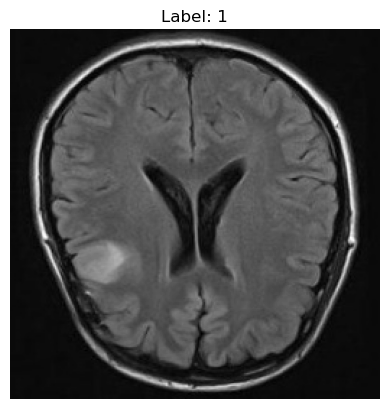

Image_No: 2730


In [4]:
number = random.randint(0, 2999)
image, label = image_set[number]
image = np.transpose(image, (1, 2, 0))

# Display the image in grayscale
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
print(f"Image_No: {number}")

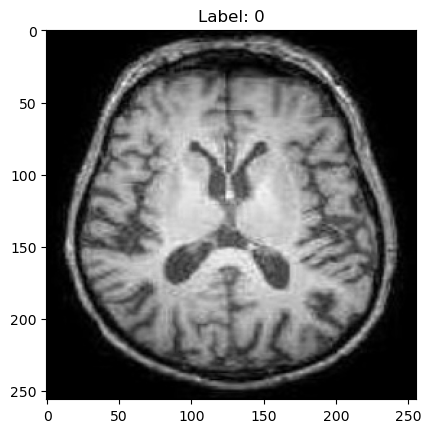

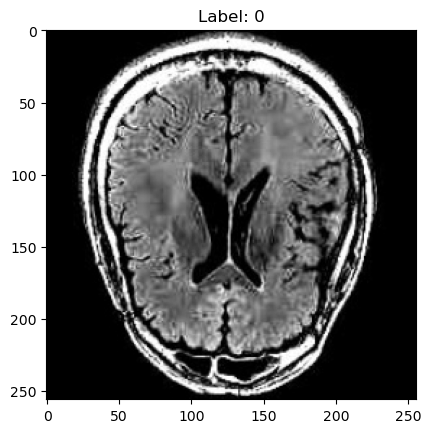

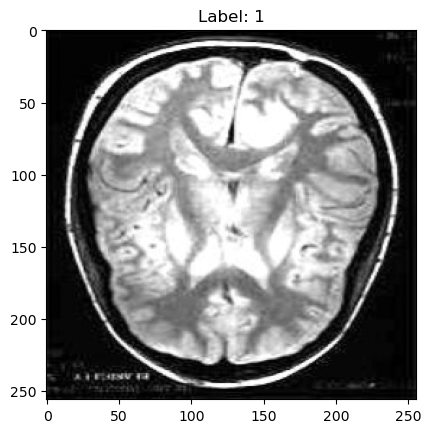

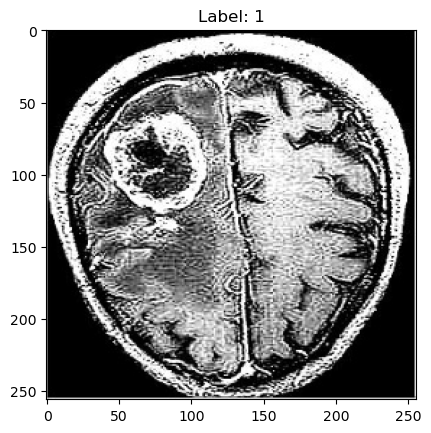

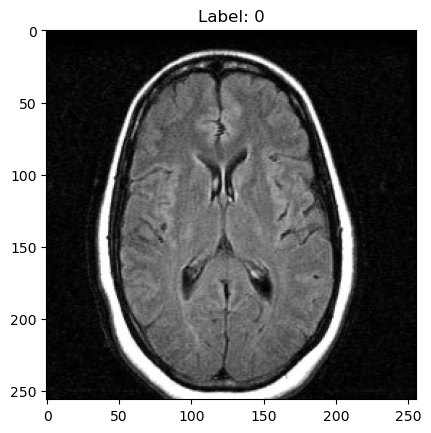

In [5]:
# Display 5 random images from train_loader in original form
# To confirm we have successfully loaded images ready for training
def unnormalize(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # transpose the dimensions
    return img

images, labels = next(iter(train_loader))

# Visualize the first 5 images and their labels
for i in range(5):
    plt.imshow(unnormalize(images[i]), cmap='gray')
    plt.title('Label: {}'.format(labels[i]))
    plt.show()

In [6]:
# pytorch to tensorflow converter, so that data can be read by tf model
def convert_to_numpy(loader):
    data = []
    labels = []
    for batch in loader:
        images, batch_labels = batch
        data.append(images.numpy())
        labels.append(batch_labels.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    # Reshape the data to (batch_size, height, width, channels)
    data = data.reshape(-1, 256, 256, 1)
    return data, labels

x_train, y_train = convert_to_numpy(train_loader)
x_val, y_val = convert_to_numpy(val_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Model construction and training
### This notebook skips these steps

In [7]:
model = tf.keras.models.load_model('tumour_detector.h5')

# Visualise CNN confidence on testing dataset
### Bar represents CNN confidence on each of 2 categories

1/1 [==============================] - 0s 97ms/step


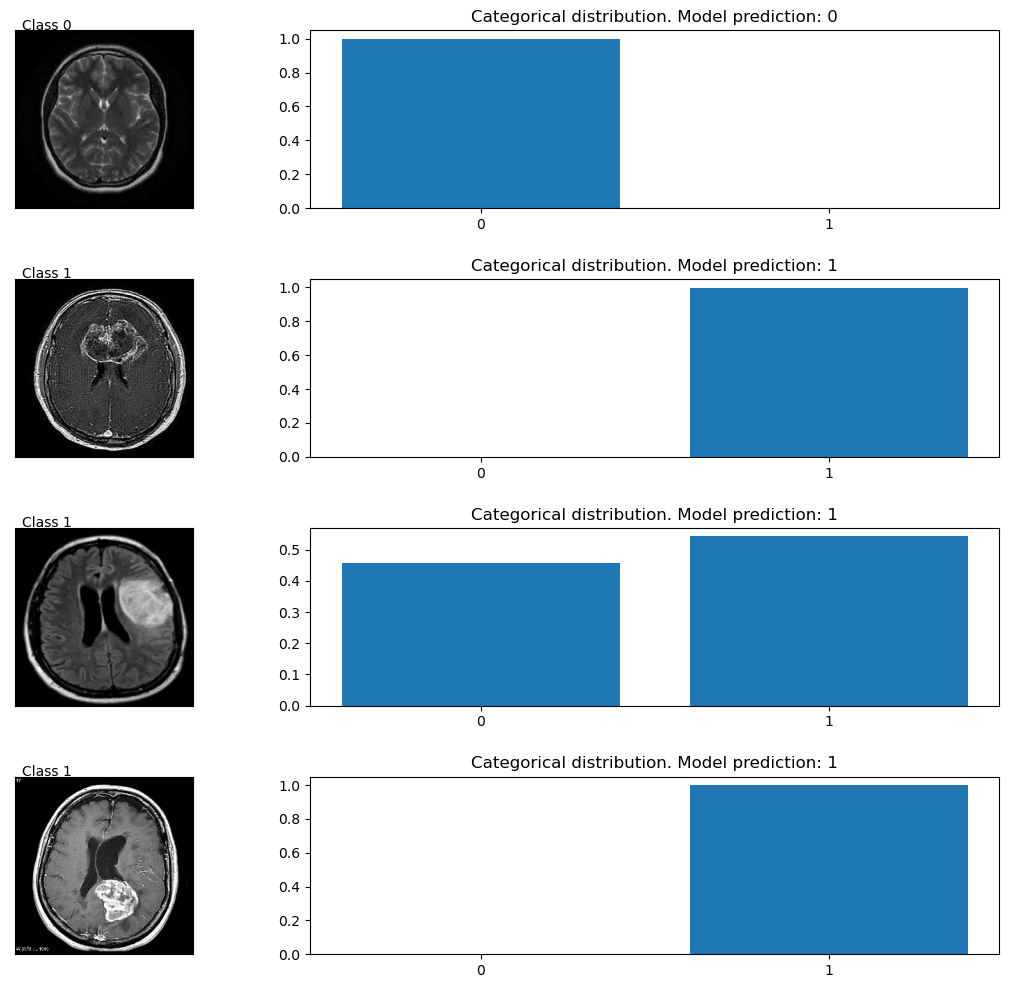

In [8]:
# visualise our model's confidence (decision making) on yes/no categories in several testing images
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)
complement = np.ones_like(predictions) - predictions
predictions = np.concatenate((complement, predictions), axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap = 'gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Class {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

# Visualise model predictions on the prediction dataset

In [9]:
# Get prediction images from pred_output folder and visualise CNN decision making
from PIL import Image

pred_path = 'brain-tumour-project/Br35H/pred_output'
img_filenames = os.listdir(pred_path)
img_width, img_height = 256, 256

def convert_to_numpy(pred_path, transform):
    img_filenames = os.listdir(pred_path)
    img_width, img_height = 256, 256
    
    # Create a numpy array to store the images:
    imgs = np.zeros((len(img_filenames), img_width, img_height), dtype=np.float32)

    # Loop through the image filenames, load each image, and preprocess it:
    for i, filename in enumerate(img_filenames):
        img = Image.open(os.path.join(pred_path, filename))
        img = transform(img)
        imgs[i] = img
    
    # Reshape the data to (batch_size, height, width, channels)
    imgs = imgs.reshape(-1, img_width, img_height, 1)
    return imgs

pred_imgs = convert_to_numpy(pred_path, transform)

1/1 [==============================] - 0s 36ms/step


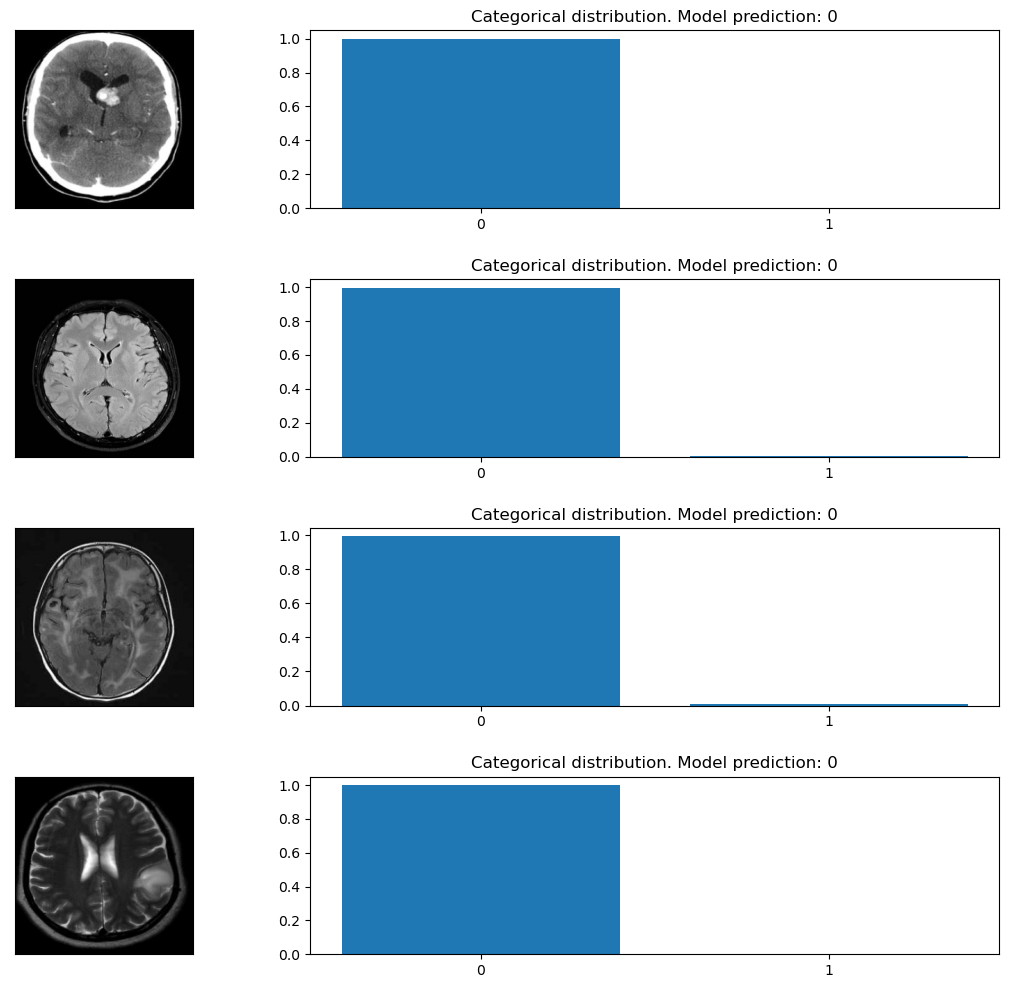

In [10]:
num_test_images = pred_imgs.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_test_images = pred_imgs[random_inx, ...]

predictions = model.predict(random_test_images)
complement = np.ones_like(predictions) - predictions
predictions = np.concatenate((complement, predictions), axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image) in enumerate(zip(predictions, random_test_images)):
    axes[i, 0].imshow(np.squeeze(image), cmap = 'gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()